# SPM12 PIPELINE (ContLTM_IEM) (PS 6/27/18)

## File Setup
* Create a folder for each task (e.g., ObjScram folder will contain all the ObjScram runs), as well as one for MPRAGE.
* Create DICOM folder within each of these task-specific folders, place all respective DICOMS (from PacsOne) in their folder.
* Download Xiangrui's [dicm2nii](https://www.mathworks.com/matlabcentral/fileexchange/42997-dicom-to-nifti-converter--nifti-tool-and-viewer) function and convert all DICOMS into 3D nifti files ('4' argument at the end), repeat for each task-specific DICOMS folder.
   * This outputs n nifti files per run, n = number of volumes.

In [ ]:
dicm2nii('DICOM_FOLDER','DICOM_FOLDER',4)

# Preprocessing

## Slice-Timing Correction
Slice-Timing refers to the correction of slices that were originally acquired at slightly different times, despite coming from the same TR.

Some sources like Poldrack's fmri handbook say that if TR is < 2s and doing event-related design (or using multiband), you don't need slice timing corrections. However more recently there seems to be at least some benefit to _always_ doing slice timing correction, [even for short TRs using multiband](https://en.wikibooks.org/wiki/SPM/Slice_Timing) (see section 2.3.6).

* In the GUI, click Slice Timing.
* Click Data. Create a new session. In SPM they use the word "session" instead of "run".
* Click Session. Specify all .nii files for the first run of this task. 
* Click Data. Replicate Session (1) up till the number of runs that you had for this task.
* Repeatedly select the .nii files for the respective run. 
* Number of Slices. To find this, open dcmHeaders.mat that gets output after running dicm2nii and find the name of one of the structs (e.g., h.ColorGrayContrast_1). Open that and find SliceTiming. Length of SliceTiming equals the number of slices for that run (should be equivalent across runs of the same task).
* TR. Enter your TR in seconds. 
* TA. For multiband, this equals zero. Else, calculate it as TR-(TR/nslices).
* Slice Order. See below:

If not using multiband, slices are likely interleaving ascending (at least currently for CCBBI). So specify [1:2:totalSlices,2:2:totalSlices] as your slice timings (double click Slice order in GUI). SPM GUI accepts typical Matlab syntax. 

For multiband, open dcmHeaders.mat. Run the following script to get spm_ms, which is a vector of the correct slice timing acquisitions. Double click Slice order in the GUI, input spm_ms, and click OK.

In [ ]:
s = h.ColorGrayContrast_1; % field name is the same as nii file name
spm_ms = (0.5 - s.SliceTiming) * s.RepetitionTime;

* Reference Slice. First slice acquired (i.e., 0 for first acquired slice onset). Although reference slice is up to you, just be consistent.
* Save Batch and Script (this outputs the Matlab code that runs the current GUI sequence. Useful for automating preprocessing later on.)
* Run by clicking the green arrow at the top of the GUI.
* Slice-timing corrected files have the prefix "a".

## Realignment (Estimate & NOT Reslice)
Realignment in SPM takes the first volume of a run and makes this the reference scan for all the other volumes of the same run. These other volumes are then spatially transformed according to 6 parameters (i.e., rigid body transformation, which is a kind of affine transformation, which encompasses translation, rotation, stretching, or shearing along each axis. The difference between affine transformation and rigid body transformation is that the latter assumes the brain does not change size or shape over time, whereas a full affine transformation would contain 12 parameters: each operation for each dimension represented by a single parameter).

The estimate portion of Realignment here refers to a set of realignment parameters (realignment of all volumes to the reference volume to minimize movement artifacts) saved for each run in a text file (rp_*.txt), as well as a mean functional volume, important for coregistering the functional images to the anatomical. Reslice refers to transforming the volumes to match the reference volume voxel-for-voxel, which we DO NOT want to do yet since in this pipeline we later reslice during the coregistration step. You only ever want to reslice your volumes first. Doing "estimate" and not "estimate and reslice" gives you the same output files but the output files are not resliced yet, just saved with the realignment parameters which are automatically used when the next reslicing step comes along.

* In the GUI, select Realign (Estimate). It's the same procedure as for slice-timing in terms of adding "sessions" for each run. This time within each session select the slice-timing corrected .nii files instead of the uncorrected .nii files.
* Defaults are fine. Save Batch and Script and then run. Outputs realigned .nii files with prefix "r". A mean functional run (mean of the resliced images) will also be output. The filename will have a 1 at the end which may make you think it's only the mean of the first run, but it's actually the mean of all the runs that were realigned.

* If using the GUI it will spit out a line graph showing you subject movement. Check to make sure movement within a run wasn't excessive (>2 mm or so?) and doesn't contain sudden changes in movement. If using batch scripts, you'll just get the txt file. To revisualize the line graph from the txt file, use the following commands:

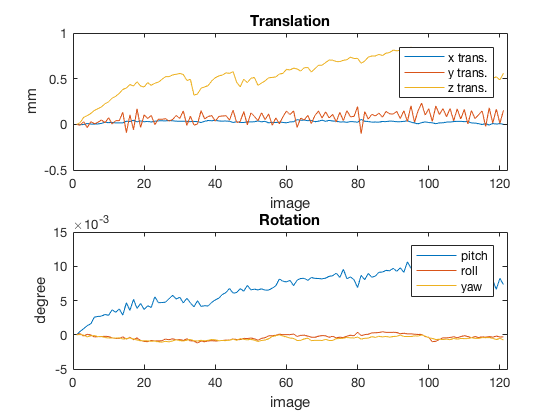

In [3]:
rp = load('/Users/scotti.5/Documents/OSU/fMRI/ContLTM_IEM/101/ColorLocalizer/nii/rp_aColorGrayContrast_1_00001.txt'); %select the rp*.txt file
figure;
subplot(2,1,1);plot(rp(:,1:3));
title('Translation');
ylabel('mm'); xlabel('image');
legend({'x trans.','y trans.','z trans.'});
set(gca,'xlim',[0 size(rp,1)+1]);
subplot(2,1,2);plot(rp(:,4:6));
set(gca,'xlim',[0 size(rp,1)+1]);
title('Rotation');
ylabel('degree'); xlabel('image');
legend({'pitch','roll','yaw'});

## Coregistration (Estimate & Reslice)
Align functional volumes to the high-res anatomical (MPRAGE). This will help us identify what activations go with what structural region.

* Following 4 bullet points are only necessary if you plan on later transforming into template space, rather than sticking with native space (which I am not doing for ContLTM_IEM). The multi-step normalization method we could take is as follows: realign fMRI volumes to first volume in the run -> coregister these aligned volumes to the high-res MPRAGE -> normalize the MPRAGE (and coregistered functional images) into template MNI space
* Before clicking Coregistration in the GUI, we need to refit the origin of MRPAGE. Click "Display" on the GUI and open MPRAGE.nii.
* Click on the center of the anterior commisure as best as you can in the three slice orientations.
* In the crosshair position box, you'll see three values next to "mm:". Take the negative of the first value and input that as "right {mm}". Take negative of second value and input as "forward {mm}". Take negative of the third value and input as "up {mm}". Click Reorient and save over the MPRAGE.nii.

* This sets the 0,0 point on the MPRAGE to roughly the location of the anterior commisure, which will help with later transforming the MPRAGE into a template space (i.e., MNI space). This helps because the closer the positions of the template space and the MPRAGE, the less likely subsequent transformations are to fall into a local minimum rather than global minimum during spatial normalization.



* In GUI, select Coregister (Estimate & Reslice) (note that if you are doing normalization then you should not reslice at this step).
* Reference Image is your MPRAGE. 
* Source Image is your mean functional volume for the first run. Was previously output during realignment. 
* Other Images is all the realigned functional volumes, for all runs. 
* Defaults are fine. Save Batch and Script and then run.

What happens here is that the mean functional run will be overlaid to the MPRAGE. The overlay may not be perfect right off the bat so that image is jittered around using rigid body transformations until it is best overlaid. Then this same transformation is applied to all the Other Images. The mean functional and all the other images are linked to the MPRAGE now so that if we later transform the MPRAGE, all these images will also be transformed.

#### Not performed: Normalization (Estimate & Write)
Alignment of data into a common spatial framework so that data may be compared/combined across individuals.

"Write" just refers to actually applying the "estimated" warps to the series of images.

* In GUI, select Normalization (Estimate & Write). Double click Data.
* Image to Align is the MPRAGE. This MPRAGE will get transformed into MNI space.
* Images to Write are all the coregistered, realigned, slice-corrected functional volumes (prefix "rra") AS WELL AS the same MPRAGE above that you selected as the Image to Align.
* In SPM12, the tissue probability map (TPM.nii) defines what template you will be warping your images to (SPM12 uses MNI-152 space). TPM.nii is a 4D image that contains a total of 6 3D images of the following modalities: gray matter, white matter, cerebrospinal fluid, fat tissue, bone tissue, and air. 
* Side note: there is a default parameter under Estimation Options that says Affine Regularisation, and is set to ICBM space template - European brains. This is not the same template space that is used for normalization, and apparently the option you choose here hardly affects anything at all (at least according to what I've read. You could also experiment with different options and see for yourself). Affine Regularisation refers to setting the anticipated amount of transformation needed during normalization.
* Save Batch and Script and run. Output files have "w" prefix.

## Spatial Smoothing
Blurring data to reduce noise. Useful for increasing the power of simple contrasts. Don't use if doing MVPA, IEM, or retinotopic mapping analyses. Do use if identifying, say, functional ROIs.

* In GUI, select Smooth.
* Images to smooth should be all your volumes (prefix "rra" if following all the above steps), including all runs. 
* Change FWHM to [4 4 4]. The default of [8 8 8] is a larger smoothing kernel than we typically want.
* Save Batch and Script and run. Output files have "s" prefix.

# Processing 

## 1st-Level Contrast (Single-Subjects Analysis)
Statistical analysis using General Linear Models (for single-subject univariate contrasting of conditions using block or event-related designs). SPM refers to 2nd-Level as group-level contrasts.

* In GUI, click Specify 1st-level 
* Directory sets where the SPM.mat file is saved. This file will contain the design matrix to be used for specifying contrasts.
* Under Timing parameters, Units for design: set to Seconds
* Interscan interval is your TR (in seconds)
* Data and Design - click new Subject/Session
* Scans: select your most recently preprocessed (e.g., "srra" prefix) volumes, only for the first run.
* Double click Conditions. Let's say we have conditions A and B that we want to contrast. 
* Specify Name as "A". 
* Specify Onsets as the onset (to nearest TR) of either the condition-A blocks, or the condition-A stimulus onsets if using event-related design.
* Duration - end of stimulus OFFSET
* Save Batch and Script and run. Outputs SPM.mat

You should finish with an SPM.mat file that, when viewed (you can view using the Review button in the GUI and selecting your SPM.mat file) looks something like this (this was a color localizer, with 3 conditions (color, grayscale, fixation) and 2 runs): 
![](https://puu.sh/ANscj/eeb6f17378.png)

## Model estimation

* In GUI, select Estimate
* Select SPM.mat - select your just created SPM.mat file
* Run

## Create Contrast

* In GUI, select Batch
* At the top of the Batch Editor, click the SPM tab at the top, then select Stats > Contrast Manager
* Select your SPM.mat file
* Contrast Sessions > New: T-contrast
* Name the contrast whatever you are contrasting (e.g., Stimulus > Fixation)
* Weights vector. If you input the first condition as stimulus and the second as fixation, then you should specify a vector of [1 -1]. Also add zeros equal to the number of motion parameters (6 for rigid body transformation) and another 0 at the end for the constant value. Thus in this example the weights vector would be [1 -1 0 0 0 0 0 0 0]. 
* Replicate over sessions. If you have more than one run, then you should click Replicate. Otherwise, click Don't replicate.
* Outputs several files including beta weights and t-statistic file

## Visualize

* Download bpsmview toolbox and add it to the toolbox folder in the SPM installation folder 
* In GUI, click Toolbox and select bpsmview. Open your T-statistic file (spmT_0001.nii)
* Load > New Underlay > MPRAGE.nii

Example:
![](https://puu.sh/AMSro/8face1d0fa.png)

**If done in batch, the full processing of 2 runs starting from preprocessing the original 3d nifti files all the way to the finished visualization took me around 30 mins.** 

# Extracting ROIs from functional data

Download MarsBaR toolbox for SPM. 
1. Click ROI definition dropdown and select "Get SPM Clusters"
2. Select your SPM.mat file and fill out boxes that come up (I used "none" "none: p=.001" "none")
3. Select the ROI cluster in the visualization window
4. Write ROIs > Write one cluster
5. ROI definition > Export > Image
6. From image > MPRAGE

# Retinotopic Mapping using Freesurfer (FSFAST)

**Requires that you install Freesurfer and run all of recon-all on the 4d .nii MPRAGE** 

To convert from DICOMs to 4d .nii instead of 3d using dicm2nii, use "0" as the end argument instead of "4" as used above.

**How does retinotopic mapping work? (explained for my own benefit)** 

The mapping from retina to EVC is topographic, meaning that neighboring regions in one area of the retina project to corresponding regions in the EVC. Similar mapping is preserved at later cortical stages (V2, V3, V4, etc) as well, in such a way that successive visual areas alternate with mirror or non-mirror representations of the visual field (note that going into parietal or temporal lobes it becomes increasingly difficult to show retinotopic organization). We exploit this fact by using phase-encoded visual stimuli to reveal meridian representations and separate these distinct visual areas. This method was first described in Sereno et al., 1995. 

Phase-encoded retinotopic mapping is based on the assumption that when a stimulus changes cyclically along a particular dimension (in this case, polar angle), the signal of neuronal populations selective for that dimension will also be cyclically modulated. We can then take a look at a voxel's functional time course and see at what phase it is maximally responding. Is it just a sine wave? Then it's the horizontal meridian. Is it a cosine wave? Looks like that's a voxel representing the vertical meridian. And so on for all degrees in-between. 

This gives us the estimate of the signal phase, but doesn't give us amplitude. To do that, one way would be to run a GLM and use sine/cosine as regressors in the design matrix. The most common method, however, is to calculate a fast Fourier transform of the observed time series, which gives both phase and amplitude (the "fast" just refers to a way of computing fourier transforms faster than before, which is computational mumbo-jumbo we don't need to get into). We should know, however, the basics of how Fourier transforms work (important for fMRI overall not just retinotopy), explained very clearly by Geoffrey Aguirre in this video: https://youtu.be/J1XYcIj86TI?t=1h16m19s. "If you take any signal over time, you can express it as the sum of sinusoids of different frequencies and amplitudes. ... This can be expressed as a power spectrum."

## Flattening the brain
Recon-all inflates the brain but does not flatten it. You need to manually cut the inflated brain in order to flatten the surface. For all steps of retinotopic mapping assume that you need to do everything twice, once for each hemisphere. 

* Open your subjects inflated brain in tksurfer (using terminal: tksurfer ContLTM_s101 lh inflated)
* Load the curvature map (displays gyri and sulci) (File > Curvature > Load Curvature ... default should be correct, the lh/rh.curv file)
* Make patch of occipital lobe (see https://afni.nimh.nih.gov/pub/dist/edu/human_freesurfer/fs_hands-on/fs_hands-on.pdf slides 38-39)
* File > Save Patch as ?h.occip.patch.3d (replace ? with l or r depending on hemisphere)
* In terminal: 

In [ ]:
mris_flatten -w 0 -distances 20 7 lh.occip.patch.3d  lh.occip.patch.flat && \
mris_flatten -w 0 -distances 20 7 rh.occip.patch.3d  rh.occip.patch.flat

To understand what the different arguments do, read the documentation (i.e., "mris_flatten" and "mris_flatten -help"). The 20 7 here is just a generally used size/number of vertices at each distance. 

Note that we aren't talking in voxels anymore. 3D voxels have been converted to 2d triangles during inflation (the points of these triangles are called vertices and the connections between triangles called edges). Vertices contain information about GM volume, thickness, curvature, area, etc. The inflation then gets cut up based on the calcarine sulcus we specified, and flattened out. 

Note that when using Bash in terminal, the && at the end means to execute the current line and only if that line is successfully executed, to continue to execute following lines. You'd use a semicolon instead of && if you wanted the following lines to be executed even if the current line failed. The \ stands for a line break.

---

Now that you have the flattened occipital patch, we need to setup the directory of functional retinotopic mapping runs. Freesurfer is VERY particular about where your files are located and what they are named. Create a new folder in the root directory of your freesurfer folder (where FREESURFER_HOME directs to), and name it retinotopy. Create a folder for your subject (here SUBJ01, doesnt need to match the same name you used in the subjects folder). Inside that folder create a folder named "bold" and inside that folder create a separate folder for each retinotopic mapping run, as well as one additional folder if you have only polar runs and not eccentricity. Name each of these retinotopic mapping runs a three digit number. 

Download the 4d .nii file of each (unprocessed) run and copy them into their corresponding folders. Rename each of these files as "f.nii". If you created the extra folder, just copy one of the "f.nii" to it. Basically a later command we use only gets completed if there is an eccentricity run available for it to process, so we need to fake the existence of at least one eccentricity run if we are only using polar maps. (This workaround was offered by Doug Greve on the freesurfer mailing list.)

![](https://puu.sh/ANv4r/f6e3a567b3.png)

Create a txt file, type the name of the subject you are about to process (e.g., "SUBJ01") in the txt file, save the file as "sessid" without the .txt suffix.  Place this file in the root of the retinotopy folder you created.

Create a txt file, type the name of this subject's folder located in the "subjects" freesurfer folder (the folder containing this individual's inflated brain and other files) in the txt file, save the file as "subjectname" without the .txt suffix, and place this file in the SUBJ01 folder (in this example). 

For each 3-digit number folder, create a txt file and save it as "rtopy.par". In this file, type the following:

In [ ]:
stimtype polar
direction pos

Change polar to "eccen" if the run is an eccentricity run, and change the direction to "neg" if wedges were rotating counterclockwise. It actually doesn't matter how you specify "pos" or "neg" as long as the opposite direction runs (or opposite direction extending inward or outward) are named differently. Again, if you only have polar runs you need to specify "eccen" for stimtype in the extra folder you created.

You are now ready to process the runs into a format that will overlay polar field maps on the flattened brain. Note that you cannot bypass any of these steps, such as processing the runs in a different software and then skipping the propoc-sess step, because each of these commands creates files in a very specific way such that you'll encounter errors if you try to side-step around any of them.

In [ ]:
preproc-sess -sf sessid -df SUBJ01 -surface self lhrh -fwhm 0 -fsd bold -per-session && \
mkanalysis-sess -a rtopy.self.lh -surface self lh -TR 2 -retinotopy 24 -paradigm rtopy.par -per-session -fsd bold -fwhm 0 -ngroups 3 && \
mkanalysis-sess -a rtopy.self.rh -surface self rh -TR 2 -retinotopy 24 -paradigm rtopy.par -per-session -fsd bold -fwhm 0 -ngroups 3 && \
selxavg3-sess -a rtopy.self.lh -sf sessid && \
selxavg3-sess -a rtopy.self.rh -sf sessid

Briefly, here's what each command is doing:

**preproc-sess**: Preprocesses each run, with no smoothing (fwhm 0), and aligning motion correction to the start of the 1st run (-per-session).

**mkanalysis-sess**: First-level FSFAST analysis. TR 2 is your TR, retinotopy 24 is the period (sec) of the retinotopy design, again no smoothing (fwhm 0), and with an m-factor of 3 (-ngroups 3) (if not using multiband, no need for -ngroups). 

**selxavg3-sess**: Takes all the files from mkanalysis-sess and opens up MATLAB to perform further analyses. This step does the actual calculations of areas responding more or less to certain spatial locations on the screen. It assumes that your wedges start at the horizontal meridian (which ours do but important to note).

If you ever need to redo a step, you'll have to add "-force" to the end of the command, otherwise it sees that the proper files were already output and doesn't do anything.

If you encounter an error during selxavg3-sess, it's possible that you don't have MATLAB properly linked with Freesurfer. To remedy this, use the command "export PATH=$PATH:/Applications/MATLAB_R2017a.app/bin". Change the MATLAB file to whatever yours is.

To visualize your retinotopic maps, use the following command (this is for left hemisphere) after changing directory to the retinotopy folder. You may need to change some of these file names around to suit how you named your subject. Note that rtview is a variant of tksurfer, especially created for proper overlaying of retinotopic maps that can support coloring via a color wheel.

In [ ]:
rtview --s ContLTM_s101 --hemi lh --polar --real SUBJ01/bold/rtopy.self.lh/polar/real.nii.gz --imag SUBJ01/bold/rtopy.self.lh/polar/imag.nii.gz --fsig SUBJ01/bold/rtopy.self.lh/polar/fsig.nii.gz --flat

First off go to Tools > Labels > Delete All Labels, we don't need any of it and will be making our own labels which would just get cluttered up with all of these premade ones. 

Then go to View > Configure > Overlay 
Select the following options and hit Apply at the bottom. The threshold is in a weird format, it's not correlation values. The default Min and Max are set to p<.01, and any changes you do to Min and Max after that are arbitrary. So setting Min to 0.05 and Max to 0.1 is just one way to decrease the threshold to better visualize polar maps, but it doesn't really mean anything statistically. Also note that it's not enough to replace the text inside the text boxes with a different number, you have to hit enter to confirm that new value, and THEN hit Apply. You can change Min to 0.1 if you want to increase the threshold.

![](https://puu.sh/APD9m/d5a6693ef2.png)

Now you can actually see the stripes on the occipital patch. 

Here is the color wheel used, for reference:
![](https://puu.sh/AJpdK/a0c27e5f3a.png)

You need to flip the image left-to-right if examining left hemisphere, such that ventral always goes green->yellow->red and dorsal always goes green->blue->red.

If you need to figure out the exact polar radian that corresponds to a certain color, you can look at [this Matlab code](https://drive.google.com/file/d/15LDx1oYm_n1zjI_bADt8TRsoScSsTvWb/view?usp=sharing) that constructed the above color wheel. 

When defining regions, follow this mnemonic: half, half, half, full. Meaning that, starting from calcarine sulcus, you go half rotation around color wheel (thus defining V1 for one hemisphere), then again (V2), and again (V3), and then all the way around (V3a/b if dorsal / V4 if ventral).

Here is an example of delineated ROIs (but note this was using Brainvoyager, meaning different color scheme than what I'm using).
![](https://puu.sh/CxAp0/7c6d259dc6.png)

You can now draw ROIs and save them as labels (see https://surfer.nmr.mgh.harvard.edu/fswiki/TkSurferGuide/TkSurferWorkingWithData/TkSurferLabel).

Extra reference (not 100% accurate, the mapping from flattened surface to 3D is not that intuitive; please correct me if you know better!):  
![](https://puu.sh/B1Kqg/73ba75090f.png)

### Exporting ROIs from Freesurfer labels

In terminal, change directory to the subject's mri folder within freesurfer. Then run the following command to transform your labels into volumes. If 30% of a voxel is encompassed by your label, it gets included. The inflated and then flattened surfaces we were using were in MNI space, so we are de-MNI-zing the labels we have (putting them back into native space according to the orig.mgz file output during recon-all) and then converting them into ROIs.

If you changed the origin of your MPRAGE.nii file for normalization, you'll also need to coregister the orig file to the MPRAGE with your ROI nifti files as "other images". Even if you didn't, you definitely should double check that your MPRAGE.nii is aligned to orig.mgz and your labels.

In [ ]:
for labelID in LH_V1v LH_V2v LH_V3v LH_V4v LH_VO1 LH_V1d LH_V2d LH_V3d LH_V3ab LH_V7
do
  mri_label2vol --label ../label/$labelID.label --temp orig.mgz --regheader orig.mgz --fillthresh .3 --proj frac 0 1 .1 --subject ContLTM_s101 --hemi lh --o $labelID.nii
done

for labelID in RH_V1v RH_V2v RH_V3v RH_V4v RH_VO1 RH_V1d RH_V2d RH_V3d RH_V3ab RH_V7
do
  mri_label2vol --label ../label/$labelID.label --temp orig.mgz --regheader orig.mgz --fillthresh .3 --proj frac 0 1 .1 --subject ContLTM_s101 --hemi rh --o $labelID.nii
done

Sanity check that the ROI is correctly situated in about the right location on the original MPRAGE. You can overlay the original anatomical and your new ROI using any visualizer you prefer.

For example in freeview:
* File > Load Volume > your newly converted .nii file and your MPRAGE file
* Double click anatomical image at the top left to bring it up in the viewer
* Lower Opacity down until you can see the two volumes overlaid 

Alternatively, keep opacity at full and just change "Color map" from Grayscale to Heat (easier to see that way).

![](https://puu.sh/APDH6/9f015c917f.png)

## Detour: Comparing ROIs made in BV and Freesurfer
Here are my V4s using retinotopic mapping in BV and in Freesurfer, for comparison (kinda hard to show without scrolling through volumes). Everything has been transformed back into native space. Orange are the functionally defined ROIs for Color>Grayscale, Green is Freesurfer retinotopically defined V4v, and Gray is BV retinotopically defined V4v. I tried my best to be consistent when drawing the ROIs on the flattened surfaces.

![](https://puu.sh/B2ipz/5c87c28bcc.png)
![](https://puu.sh/B2iqp/3740957637.png)
![](https://puu.sh/B2it3/a8c888df69.png)

Overall, the BV ROIs came out bigger than the Freesurfer ones (could be I drew them bigger in BV despite my trying not to), and seemingly more inferior in space. There is more overlapping of the color ROIs with the Freesurfer ROIs, but only by a little. Neither Freesurfer or BV adequately cover the color ROIs in the left hemisphere, but they both do okay in the right hemisphere. The Freesurfer ROIs look more "patchy" than the BV ones, but that may have to do with the fillthresh I used (here it was .3, I will try decreasing in future attempts).

# Combining ROIs

Open up terminal and use fslmaths to combine ROIs, then convert from the compressed nii.gz to the uncompressed .nii which is necessary for future steps in SPM:

In [ ]:
fslmaths LH_ColorROI.nii -add RH_ColorROI.nii ColorROIs
mri_convert ColorROIs.nii.gz ColorROIs.nii

# IEM: Deconvolving BOLD for single trials

Using Emma's approach, which is a modification to the LS-S approach described in Mumford et al. (2012) (the difference is that Mumford et al. do all trials individually, whereas here, for example, all trial 1s across runs are a single GLM, which is easier on computer space and time to process).

A new design matrix is created for each trial, across runs. All “Trial 1s” are modeled together and all “Trial 2s” together, etc, giving 40 GLMs (40 = num of trials). The idea is that because we are randomizing everything within runs, there should be nothing systematic about all the Trial 1s and all the Trial 2s, etc. We are also including run constants to pull apart the runs, so it shouldn’t lead to issues in the multivariate analyses. All the non-trial-of-interests are also regressed out, yielding the following design matrix (for example trial 3):
![](https://puu.sh/B2m3M/8072abff11.png)

Close-up of one run:
![](https://puu.sh/B2m3Q/7c60f2e55f.png)



# Getting Single Trial Betas within your ROI

My code is available here: https://github.com/PaulScotti/IEM_ContLTM/blob/master/DoBetaSeries.m

It takes in an ROI and an SPM.mat file and outputs a struct "mydata" containing (amongst other things) mydata.betas, which is a nTrials x nVoxels matrix containing beta weights for voxels included in your ROI.
---